In [25]:
#python 3.8.12
import pandas as pd #1.3.5
import numpy as np #1.21.3
import matplotlib # 3.5.1
from matplotlib import pyplot as plt

import os
import datetime


print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.3.5
1.21.3
3.5.1


# Problem 1

Read data

In [26]:
root_dir = os.path.realpath(os.getcwd())
data_path = root_dir + '/../../instructions/gorilla_test_data.xlsx'
assert os.path.exists(data_path), f"{data_path} does not exist"


In [27]:
df_meter = pd.read_excel(data_path, 'meter_list')
print(df_meter.shape)
print(df_meter.dtypes)
df_meter.head()

(4, 3)
meter_id      int64
aq_kwh        int64
exit_zone    object
dtype: object


,meter_id,aq_kwh,exit_zone
0,14676236,28978,EA1
1,34509937,78324,SO1
2,50264822,265667,NT1
3,88357331,484399,SE2


In [28]:
df_forecast = pd.read_excel(data_path, 'forecast_table')
print(df_forecast.shape)
print(df_forecast.dtypes)
print(df_forecast.isna().sum().sum())
df_forecast.head()

(3412, 3)
meter_id             int64
date        datetime64[ns]
kwh                float64
dtype: object
0


,meter_id,date,kwh
0,14676236,2020-06-01,22.070768
1,14676236,2020-06-02,19.170720
2,14676236,2020-06-03,23.555111
3,14676236,2020-06-04,18.220712
4,14676236,2020-06-05,14.196134


In [29]:
df_rate = pd.read_excel(data_path, 'rate_table')
print(df_rate.shape)
print(df_rate.dtypes)
df_rate.head()

(1140, 5)
date              datetime64[ns]
exit_zone                 object
aq_min_kwh                 int64
aq_max_kwh               float64
rate_p_per_kwh           float64
dtype: object


,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,NaN,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524


In [30]:
# There are rows with NaNs. Ignore them. Alternative: impute some value, like 0 or inf
df_rate = df_rate.loc[~df_rate['aq_max_kwh'].isna(), :]
print(df_rate.isna().sum().sum())
df_rate.head()

0


,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524
6,2020-04-01,EA3,0,73200.0,0.2564


Calculate total cost and consumption. Assumes possibility that multiple meters may have same exit zone

In [31]:
def calculate_cost(df_meter, df_rate, df_forecast) ->pd.DataFrame:
    n_meter_ids = df_meter.shape[0]
    df_meter = df_meter.copy()
    df_meter['total_estimated_consumption_kwh'] = np.nan
    df_meter['total_cost_pounds'] = np.nan

    def map_rate_by_date(x: pd.Series, df_rate_subset: pd.DataFrame)->pd.Series:
        date = x['date']
        where = np.where(np.logical_and(df_rate_subset['date']<=date, date<=df_rate_subset['end_date']))[0][0] # date between
        rate_p_per_kwh = df_rate_subset.loc[where, 'rate_p_per_kwh']
        x['rate_p_per_kwh'] = rate_p_per_kwh
        return x

    for i in range(n_meter_ids):

        # Get subset of rate for this meter
        meter_info = df_meter.loc[i,:]
        exit_zone = meter_info['exit_zone']
        aq = meter_info['aq_kwh']
        bool_ = (df_rate['exit_zone']==exit_zone) & (df_rate['aq_min_kwh']<=aq) & (df_rate['aq_max_kwh']>aq)
        if np.count_nonzero(bool_) == 0:
            # No rates, meter probably surpassed aq range
            continue
        df_rate_subset = df_rate[bool_].copy()
        df_rate_subset['meter_id'] = meter_info['meter_id']
        assert(np.unique(df_rate_subset['date']).shape[0] == df_rate_subset.shape[0])

        # create init date and end date
        df_rate_subset.sort_values(by='date', ignore_index=True, inplace=True)
        n_rows_rate = df_rate_subset.shape[0]
        df_rate_subset['end_date'] = (df_rate_subset.loc[1:, 'date'].reset_index(drop=True) - 
            pd.to_timedelta(1, 'days')) # 1 day before next row
        df_rate_subset.loc[n_rows_rate-1, 'end_date'] = datetime.datetime(year=5000, month=12, day=30) # far future

        # Get costs per day and meter 
        df_forecast_subset = df_forecast[df_forecast['meter_id'] == meter_info['meter_id']]
        df_forecast_subset = df_forecast_subset.apply(lambda x: map_rate_by_date(x, df_rate_subset), axis=1)
        total_cost = np.sum(df_forecast_subset['kwh'] * df_forecast_subset['rate_p_per_kwh'])
        total_cost_pounds = np.round(total_cost * 0.01, decimals=2)
        total_consumption = np.round(df_forecast_subset['kwh'].sum(), decimals=2)

        df_meter.loc[i, 'total_estimated_consumption_kwh'] = total_consumption
        df_meter.loc[i, 'total_cost_pounds'] = total_cost_pounds
    return df_meter[['meter_id', 'total_estimated_consumption_kwh', 'total_cost_pounds']]

df_costs = calculate_cost(df_meter, df_rate, df_forecast)
df_costs


,meter_id,total_estimated_consumption_kwh,total_cost_pounds
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.16


# Problem 2
Function that generates a meter_list table 

In [32]:
def generate_meterlist(length, df_rate):
    valid_exit_zones = np.unique(df_rate['exit_zone'])
    random_ids = np.arange(1000, (1000+length)*100)
    random_ids = np.random.choice(random_ids, length)
    exit_zones = valid_exit_zones[np.random.randint(valid_exit_zones.shape[0], size=length)]
    aq_kwh = np.random.randint(1000000, size=length)
    df = pd.DataFrame({'meter_id': random_ids, 'aq_kwh': aq_kwh, 'exit_zone': exit_zones})
    return df

df_meter_gen = generate_meterlist(10, df_rate)
df_meter_gen

,meter_id,aq_kwh,exit_zone
0,37328,283157,NE2
1,53803,471840,EA3
2,95432,980668,EA2
3,43600,578766,SE1
4,12199,109626,SW3
5,64077,320514,SE1
6,84462,393084,NW1
7,17826,633438,SO2
8,38921,979642,NE3
9,12190,222334,WA2


# Problem 3
Assumes that there has to be data for each day and meter

In [33]:
import datetime

def generate_consumption(df_meter, start_date, duration_days):
    days_arange = start_date + pd.to_timedelta(np.arange(duration_days),'days')
    days_arange_rep = np.repeat(days_arange, df_meter.shape[0])
    meter_id_rep = np.vstack([df_meter['meter_id']] * duration_days).flatten() #repeat, but keeping order
    n_rows = meter_id_rep.shape[0]
    consumption_kwh = np.random.uniform(100, size=n_rows)
    df = pd.DataFrame({'meter_id': meter_id_rep, 'date': days_arange_rep, 'kwh': consumption_kwh})
    return df

start_date = datetime.datetime(year=2020, month=5, day=4)
duration_days = 3
df_cons_gen = generate_consumption(df_meter, start_date, duration_days)
df_cons_gen.head()

,meter_id,date,kwh
0,14676236,2020-05-04,23.484055
1,34509937,2020-05-04,4.776357
2,50264822,2020-05-04,66.434607
3,88357331,2020-05-04,4.927951
4,14676236,2020-05-05,82.711633


# Problem 4

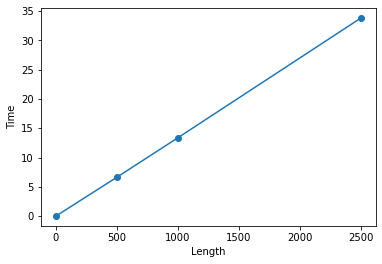

In [34]:
import time

times_l = []
lengths = [5, 500, 1000, 2500]
duration = 50
start_date = df_rate['date'].min()
for l in lengths:
    df_meter_gen = generate_meterlist(l, df_rate)
    df_cons_gen = generate_consumption(df_meter_gen, start_date, duration_days=duration)
    time1 = time.time()
    calculate_cost(df_meter_gen, df_rate, df_cons_gen)
    times_l.append(time.time()-time1)
plt.plot(lengths, times_l)
plt.scatter(lengths, times_l)
plt.xlabel('Length')
plt.ylabel('Time')
plt.show()

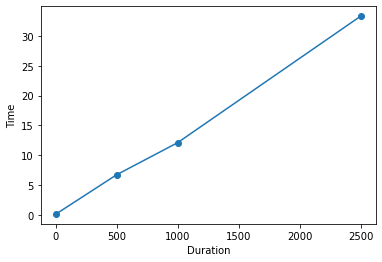

In [35]:
times_d = []
durations = [5, 500, 1000, 2500]
length = 50
start_date = df_rate['date'].min()
for d in durations:
    df_meter_gen = generate_meterlist(length, df_rate)
    df_cons_gen = generate_consumption(df_meter_gen, start_date, duration_days=d)
    time1 = time.time()
    calculate_cost(df_meter_gen, df_rate, df_cons_gen)
    times_d.append(time.time()-time1)
plt.plot(lengths, times_d)
plt.scatter(durations, times_d)
plt.xlabel('Duration')
plt.ylabel('Time')
plt.show()

# Problem 5

From the plots it seems that the time needed increases linearly with duration and length. The main point that could be improved
is the mapping of the dates in the df_forecast_subset with df_rate_subset. E.g., if we know that df_rate_subset will always be
smaller than df_forecast_subset, we could iterate along df_rate_subset instead of along df_forecast_subset.